# Analyse the tracks

In [1]:
import pandas as pd
import numpy as np
from matplotlib.ticker import MultipleLocator
from lmfit import Model,Parameter,Parameters
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from scipy.stats import norm
import os
from functions import plot_preprocessed_dist,plot_track_characteristics,mmsd_plot,cutoff_function,msd
%matplotlib inline
%reload_ext autoreload

In [2]:
files = ["Data/SM1_WNT/sm1_wnt_ld400.csv","Data/SM2_WNT/sm2_wnt_ld400.csv","Data/SM3_WNT/sm3_wnt_ld400.csv","Data/SM4_WNT/sm4_wnt_ld400.csv","Data/SM5_WNT/sm5_wnt_ld400.csv","Data/SM6_WNT/sm6_wnt_ld400.csv","Data/SM7_WNT/sm7_wnt_ld400.csv","Data/SM8_WNT/sm8_wnt_ld400.csv","Data/SM10_WNT/sm10_wnt_ld400.csv"]
#files = ["Data/SM1/sm1_ld400.csv","Data/SM2/sm2_ld400.csv","Data/SM3/sm3_ld400.csv","Data/SM4/sm4_ld400.csv","Data/SM5/sm5_ld400.csv","Data/SM6/sm6_ld400.csv","Data/SM7/sm7_ld400.csv","Data/SM8/sm8_ld400.csv","Data/SM9/sm9_ld400.csv","Data/SM10/sm10_ld400.csv"]


dt = 0.05  #time step
minframe = 8
maxframe = 100

minalpha = 1.0E-03
minD = 1.0E-04
maxD = 4
maxalpha = 3

msd_model = Model(msd)
params = Parameters()
params['alpha']   = Parameter(name='alpha', value=1.0, min=minalpha,max=maxalpha)
params['D']   = Parameter(name='D', value=0.1, min=minD,max=maxD)

disp_allfiles = []

for filename in files:

    data = pd.read_csv(filename) 
    tracklist = data.TRACK_ID.unique()
    
    disp_alltracks = []
    for tid in tracklist:

        trackid = data["TRACK_ID"] == tid
        x = data[trackid]["POSITION_X"].to_numpy()   
        y = data[trackid]["POSITION_Y"].to_numpy()
                
        if len(x)<maxframe and len(x)>minframe:
            displacement_per_timelag = []
            for n in range(1,len(x)):             #for each n = each time lag
                s = 0
                disp=[]
                for i in range(0,len(x)-n):
                    disp_square = (x[n+i] - x[i])**2 + (y[n+i] - y[i])**2
                    s+=disp_square
                    disp.append(np.sqrt(disp_square))
                    
                displacement_per_timelag.append(disp)
        disp_alltracks.append(displacement_per_timelag)
    
    disp_allfiles.append(disp_alltracks)
        
print(np.shape(disp_allfiles[0]))

(3226,)


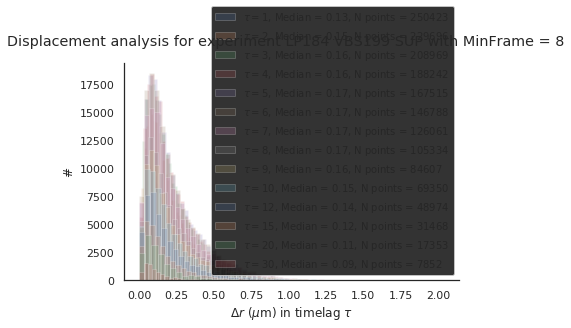

In [42]:
timelagn_array = [1,2,3,4,5,6,7,8,9,10,12,15,20,30]

hist_per_dt = []
bins_per_dt = []

N_files = np.shape(disp_allfiles)[0]
fig, ax = plt.subplots()

data = []
for tau_n in timelagn_array:
    distribution = []
    for k in range(N_files):
        N_T = np.shape(disp_allfiles[k])[0]
        for l in range(N_T):
            number_of_frames = np.shape(disp_allfiles[k][l])[0]
            if number_of_frames>=tau_n:
                disp_points = disp_allfiles[k][l][tau_n-1]
                distribution+=disp_points
    
    m=len(distribution)
    for k in range(m):
        data.append([distribution[k],int(tau_n*dt*1000)])
    
    ax.hist(distribution,bins=50,label=r'$\tau = $'+str(tau_n)+', Median = '+str(round(np.median(distribution),2))+', N points = '+str(m),alpha=0.2)
    
ax.set_ylabel('#')
ax.set_xlabel(r'$\Delta r \ (\mu$m) in timelag $ \tau $')
ax.legend(fontsize='small')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.suptitle('Displacement analysis for experiment LP184 VBS199 SUP with MinFrame = '+str(minframe))
plt.show()

In [43]:
df=pd.DataFrame(data, columns=['DISP','TIMELAG']) 
df

,DISP,TIMELAG
0,0.336214,50
1,0.247413,50
2,0.031575,50
3,0.167048,50
4,0.061008,50
...,...,...
1682627,0.065253,1500
1682628,0.065253,1500
1682629,0.065253,1500
1682630,0.065253,1500


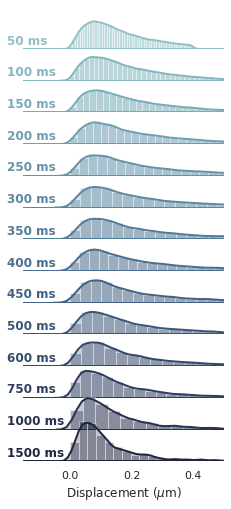

In [103]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# Initialize the FacetGrid object
pal = sns.cubehelix_palette(14, rot=-.25, light=.7)
g = sns.FacetGrid(df, row="TIMELAG", hue="TIMELAG", aspect=7, height=0.5, palette=pal)

# Draw the densities in a few steps
g.map(sns.distplot, "DISP",bins=50, kde=True,kde_kws={"lw": 2, "shade": True})
g.map(plt.axhline, y=0, lw=2, clip_on=True)

# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(-0.08, .2, label+' ms', fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)

g.map(label, "DISP")

# Set the subplots to overlap
g.fig.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[])
g.set_axis_labels("Displacement ($\mu$m)", "")
g.set(xlim=(-0.15, 0.5))
g.despine(bottom=True, left=True)